In [1]:
import gc
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, RegressorMixin

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cpu


In [2]:
DATA_PATH = Path("cup25_train_clean.csv")  # edit path if needed
df = pd.read_csv(DATA_PATH)

X = df[[f"x{i}" for i in range(1, 13)]].to_numpy()
y = df[[f"y{i}" for i in range(1, 5)]].to_numpy()

X_dev, X_int, y_dev, y_int = train_test_split(
    X, y, test_size=0.2, random_state=SEED, shuffle=True
)

print("X_dev:", X_dev.shape, "X_int:", X_int.shape)

X_dev: (400, 12) X_int: (100, 12)


In [3]:
def mee(y_true, y_pred):
    return float(np.mean(np.linalg.norm(y_true - y_pred, axis=1)))

mee_scorer = make_scorer(mee, greater_is_better=False)  # GridSearch will maximize => negative MEE


In [4]:
X_dev, X_int, y_dev, y_int = train_test_split(
    X, y, test_size=0.2, random_state=SEED, shuffle=True
)
print("X_dev:", X_dev.shape, "X_int:", X_int.shape)

X_dev: (400, 12) X_int: (100, 12)


In [5]:
import gc
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin

class TorchMLP(nn.Module):
    def __init__(self, n_in, hidden_layer_sizes=(32,), n_out=4, activation="relu"):
        super().__init__()
        act = nn.ReLU if activation == "relu" else nn.Tanh
        layers = []
        prev = n_in
        for h in hidden_layer_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(act())
            prev = h
        layers.append(nn.Linear(prev, n_out))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class TorchMLPRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        hidden_layer_sizes=(32,),
        activation="relu",
        batch_size=64,
        lr=1e-3,

        # ---- NEW: optimizer switch ----
        optimizer="adam",      # "adam", "adamw", "sgd"
        # Adam/AdamW params
        beta1=0.9,
        beta2=0.999,
        eps=1e-8,
        amsgrad=False,

        # SGD params (chỉ dùng nếu optimizer="sgd")
        momentum=0.9,
        nesterov=True,

        weight_decay=1e-4,
        max_epochs=100,
        random_state=42,
        device=None,
        verbose=0,
    ):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.batch_size = batch_size
        self.lr = lr

        self.optimizer = optimizer
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.amsgrad = amsgrad

        self.momentum = momentum
        self.nesterov = nesterov

        self.weight_decay = weight_decay
        self.max_epochs = max_epochs
        self.random_state = random_state
        self.device = device
        self.verbose = verbose

        self.model_ = None
        self.device_ = None

    def _get_device(self):
        if self.device is None:
            return torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if self.device == "cuda" and (not torch.cuda.is_available()):
            return torch.device("cpu")
        return torch.device(self.device)

    def _build_optimizer(self, model):
        opt = self.optimizer.lower()
        if opt == "sgd":
            return torch.optim.SGD(
                model.parameters(),
                lr=self.lr,
                momentum=self.momentum,
                nesterov=self.nesterov,
                weight_decay=self.weight_decay,
            )
        elif opt == "adam":
            return torch.optim.Adam(
                model.parameters(),
                lr=self.lr,
                betas=(self.beta1, self.beta2),
                eps=self.eps,
                weight_decay=self.weight_decay,
                amsgrad=self.amsgrad,
            )
        elif opt == "adamw":
            return torch.optim.AdamW(
                model.parameters(),
                lr=self.lr,
                betas=(self.beta1, self.beta2),
                eps=self.eps,
                weight_decay=self.weight_decay,
                amsgrad=self.amsgrad,
            )
        else:
            raise ValueError(f"Unknown optimizer: {self.optimizer}")

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32)
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        np.random.seed(self.random_state)
        torch.manual_seed(self.random_state)

        device = self._get_device()
        self.device_ = device

        n_in = X.shape[1]
        n_out = y.shape[1]

        X_t = torch.from_numpy(X).to(device)
        y_t = torch.from_numpy(y).to(device)

        loader = DataLoader(
            TensorDataset(X_t, y_t),
            batch_size=self.batch_size,
            shuffle=True
        )

        model = TorchMLP(
            n_in=n_in,
            hidden_layer_sizes=self.hidden_layer_sizes,
            n_out=n_out,
            activation=self.activation
        ).to(device)

        criterion = nn.MSELoss()
        optimizer = self._build_optimizer(model)

        for ep in range(self.max_epochs):
            model.train()
            for xb, yb in loader:
                optimizer.zero_grad(set_to_none=True)
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()

        self.model_ = model

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        X_t = torch.from_numpy(X).to(self.device_)
        self.model_.eval()
        with torch.no_grad():
            pred = self.model_(X_t).detach().cpu().numpy()
        return pred


In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def mee(y_true, y_pred):
    return float(np.mean(np.linalg.norm(y_true - y_pred, axis=1)))

@torch.no_grad()
def _predict_numpy_batched(model, X_np, device, batch_size=2048):
    """Fast batched prediction to reduce overhead."""
    model.eval()
    X_np = np.asarray(X_np, dtype=np.float32)
    preds = []
    for i in range(0, X_np.shape[0], batch_size):
        xb = torch.from_numpy(X_np[i:i+batch_size]).to(device)
        preds.append(model(xb).detach().cpu().numpy())
    return np.vstack(preds)

def torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params,            # pass gs.best_params_ here
    epochs=500,
    cv=None,
    random_state=42,
    pca_components=4,
    device=None,
    pred_batch_size=4096,
    use_step_lr=False,
    step_lr_step_size=50,
    step_lr_gamma=0.9,
):
    """
    Returns:
      train_mean: (epochs,)
      val_mean  : (epochs,)

    Anti-leakage:
      - Fit X scaler/PCA and y scaler on train-fold only.
      - Transform validation fold using train-fold preprocessors.
    """
    # ---- device ----
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    X_dev = np.asarray(X_dev)
    y_dev = np.asarray(y_dev)
    if y_dev.ndim == 1:
        y_dev = y_dev.reshape(-1, 1)

    # ---- Helper: fetch params regardless of prefix style ----
    def getp(key_no_prefix, default=None):
        k = f"regressor__mlp__{key_no_prefix}"
        if k in best_params:
            return best_params[k]
        if key_no_prefix in best_params:
            return best_params[key_no_prefix]
        return default

    # ---- read params ----
    hidden_layer_sizes = getp("hidden_layer_sizes", (32,))
    activation         = getp("activation", "relu")
    batch_size         = int(getp("batch_size", 64))
    lr                 = float(getp("lr", 1e-3))
    weight_decay       = float(getp("weight_decay", 1e-4))

    optimizer_name     = str(getp("optimizer", "sgd")).lower()  

    # Adam/AdamW params
    beta1              = float(getp("beta1", 0.9))
    beta2              = float(getp("beta2", 0.999))
    eps                = float(getp("eps", 1e-8))
    amsgrad            = bool(getp("amsgrad", False))

    # SGD params
    momentum           = float(getp("momentum", 0.9))
    nesterov           = bool(getp("nesterov", True))

    if cv is None:
        from sklearn.model_selection import KFold
        cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    fold_train_curves = []
    fold_val_curves   = []

    for fold_i, (tr_idx, va_idx) in enumerate(cv.split(X_dev)):
        # reproducibility per fold
        np.random.seed(random_state + fold_i)
        torch.manual_seed(random_state + fold_i)

        X_tr, X_va = X_dev[tr_idx], X_dev[va_idx]
        y_tr, y_va = y_dev[tr_idx], y_dev[va_idx]

        # ---- Preprocess (fit on train-fold only) ----
        x_scaler = StandardScaler().fit(X_tr)
        X_tr_s = x_scaler.transform(X_tr)
        X_va_s = x_scaler.transform(X_va)

        pca = PCA(n_components=pca_components, random_state=random_state).fit(X_tr_s)
        X_tr_p = pca.transform(X_tr_s).astype(np.float32)
        X_va_p = pca.transform(X_va_s).astype(np.float32)

        y_scaler = StandardScaler().fit(y_tr)
        y_tr_s = y_scaler.transform(y_tr).astype(np.float32)

        # ---- Build model ----
        model = TorchMLP(
            n_in=X_tr_p.shape[1],
            hidden_layer_sizes=hidden_layer_sizes,
            n_out=y_tr.shape[1],
            activation=activation
        ).to(device)

        # ---- Optimizer ----
        if optimizer_name == "sgd":
            optimizer = torch.optim.SGD(
                model.parameters(),
                lr=lr,
                momentum=momentum,
                nesterov=nesterov,
                weight_decay=weight_decay
            )
        elif optimizer_name == "adam":
            optimizer = torch.optim.Adam(
                model.parameters(),
                lr=lr,
                betas=(beta1, beta2),
                eps=eps,
                weight_decay=weight_decay,
                amsgrad=amsgrad
            )
        elif optimizer_name == "adamw":
            optimizer = torch.optim.AdamW(
                model.parameters(),
                lr=lr,
                betas=(beta1, beta2),
                eps=eps,
                weight_decay=weight_decay,
                amsgrad=amsgrad
            )
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")

        criterion = nn.MSELoss()

        scheduler = None
        if use_step_lr:
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=step_lr_step_size, gamma=step_lr_gamma
            )

        # ---- DataLoader ----
        train_loader = DataLoader(
            TensorDataset(
                torch.from_numpy(X_tr_p).to(device),
                torch.from_numpy(y_tr_s).to(device)
            ),
            batch_size=batch_size,
            shuffle=True
        )

        train_curve = np.zeros(epochs, dtype=float)
        val_curve   = np.zeros(epochs, dtype=float)

        # ---- Train + log per epoch ----
        for ep in range(epochs):
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad(set_to_none=True)
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()

            if scheduler is not None:
                scheduler.step()

            # Predict on train/val (scaled), then inverse-transform to original y-scale
            pred_tr_s = _predict_numpy_batched(model, X_tr_p, device, batch_size=pred_batch_size)
            pred_va_s = _predict_numpy_batched(model, X_va_p, device, batch_size=pred_batch_size)

            pred_tr = y_scaler.inverse_transform(pred_tr_s)
            pred_va = y_scaler.inverse_transform(pred_va_s)

            train_curve[ep] = mee(y_tr, pred_tr)
            val_curve[ep]   = mee(y_va, pred_va)

        fold_train_curves.append(train_curve)
        fold_val_curves.append(val_curve)

        # cleanup
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    train_mean = np.mean(np.stack(fold_train_curves, axis=0), axis=0)
    val_mean   = np.mean(np.stack(fold_val_curves, axis=0), axis=0)
    return train_mean, val_mean


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, KFold

x_pipe = Pipeline([
    ("x_scaler", StandardScaler()),
    ("pca", PCA(n_components=4, random_state=SEED)),
    ("mlp", TorchMLPRegressor(device=str(DEVICE), random_state=SEED))
])

estimator = TransformedTargetRegressor(
    regressor=x_pipe,
    transformer=StandardScaler()
)

cv5 = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_splits = list(cv5.split(X_dev))

param_grid = {
    "regressor__mlp__optimizer": ["adam"], 
    "regressor__mlp__hidden_layer_sizes": [(64, 64), (32, 16), (32,)],
    "regressor__mlp__activation": ["relu", "tanh"],
    "regressor__mlp__batch_size": [128],
    "regressor__mlp__lr": [1e-4, 3e-4, 1e-3, 3e-3],
    "regressor__mlp__beta1": [0.9],
    "regressor__mlp__beta2": [0.999],
    "regressor__mlp__eps": [1e-8],
    "regressor__mlp__amsgrad": [False],
    "regressor__mlp__weight_decay": [0.0, 1e-5, 1e-4, 1e-3],
    "regressor__mlp__max_epochs": [100],
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=mee_scorer,
    cv=cv_splits,
    n_jobs=1,      
    refit=True,
    return_train_score=True,
    error_score=np.nan,
    verbose=2
)

gs.fit(X_dev, y_dev)
print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END regressor__mlp__activation=relu, regressor__mlp__amsgrad=False, regressor__mlp__batch_size=128, regressor__mlp__beta1=0.9, regressor__mlp__beta2=0.999, regressor__mlp__eps=1e-08, regressor__mlp__hidden_layer_sizes=(64, 64), regressor__mlp__lr=0.0001, regressor__mlp__max_epochs=100, regressor__mlp__optimizer=adam, regressor__mlp__weight_decay=0.0; total time=  14.1s
[CV] END regressor__mlp__activation=relu, regressor__mlp__amsgrad=False, regressor__mlp__batch_size=128, regressor__mlp__beta1=0.9, regressor__mlp__beta2=0.999, regressor__mlp__eps=1e-08, regressor__mlp__hidden_layer_sizes=(64, 64), regressor__mlp__lr=0.0001, regressor__mlp__max_epochs=100, regressor__mlp__optimizer=adam, regressor__mlp__weight_decay=0.0; total time=   1.7s
[CV] END regressor__mlp__activation=relu, regressor__mlp__amsgrad=False, regressor__mlp__batch_size=128, regressor__mlp__beta1=0.9, regressor__mlp__beta2=0.999, regressor__mlp__eps=1e-

In [9]:
import numpy as np

best_model = gs.best_estimator_   
y_int = np.asarray(y_int, dtype=np.float32)
y_int_pred = best_model.predict(X_int)

print("Internal 20% MEE:", mee(y_int, y_int_pred))

Internal 20% MEE: 22.146068572998047


Early-stop selected best_epoch = 417 | best_val_MEE = 20.085761
Early-stop would stop at epoch = 447 (patience reached)


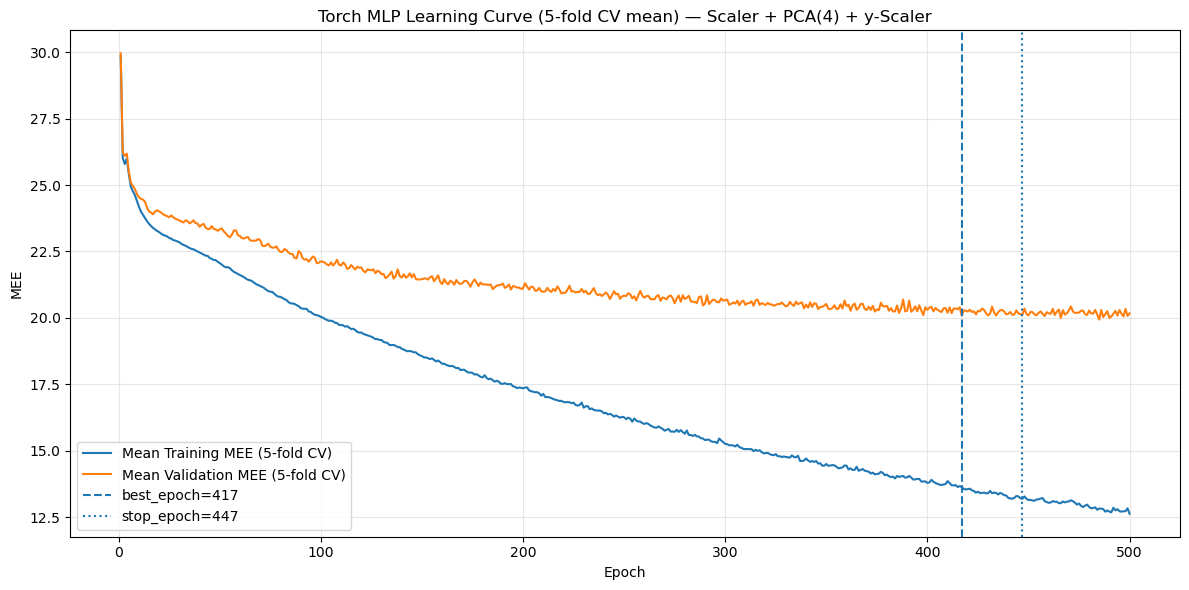

In [10]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
MLP_BEST = gs.best_params_

train_mean, val_mean = torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4,
    device=None,
    use_step_lr=False,
)

def early_stop_epoch(val_curve, patience=30, min_delta=1e-4, smooth_window=1):
    v = np.asarray(val_curve, dtype=float)

    # smoothing (moving average)
    if smooth_window and smooth_window > 1:
        k = np.ones(smooth_window) / smooth_window
        v_s = np.convolve(v, k, mode="same")
    else:
        v_s = v  # identical if smooth_window == 1

    best_val = np.inf
    best_ep0 = 0
    wait = 0
    stop_ep0 = len(v_s) - 1

    for ep0, val in enumerate(v_s):
        if val < best_val - min_delta:
            best_val = val
            best_ep0 = ep0
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                stop_ep0 = ep0
                break

    return best_ep0 + 1, stop_ep0 + 1, v[best_ep0], v_s

SMOOTH_W = 1

best_epoch, stop_epoch, best_val, val_smooth = early_stop_epoch(
    val_mean,
    patience=30,
    min_delta=1e-4,
    smooth_window=SMOOTH_W,
)

print(f"Early-stop selected best_epoch = {best_epoch} | best_val_MEE = {best_val:.6f}")
print(f"Early-stop would stop at epoch = {stop_epoch} (patience reached)")

# -------------------------
# PLOT
# -------------------------
epochs = np.arange(1, len(train_mean) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (5-fold CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (5-fold CV)")

# chỉ plot smooth nếu khác thật (smooth_window > 1)
if SMOOTH_W and SMOOTH_W > 1:
    plt.plot(epochs, val_smooth, linestyle="--", label=f"Smoothed Mean Val MEE (w={SMOOTH_W})")

plt.axvline(best_epoch, linestyle="--", label=f"best_epoch={best_epoch}")
plt.axvline(stop_epoch, linestyle=":",  label=f"stop_epoch={stop_epoch}")

plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("Torch MLP Learning Curve (5-fold CV mean) — Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

# phase 2

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, KFold

x_pipe = Pipeline([
    ("x_scaler", StandardScaler()),
    ("pca", PCA(n_components=4, random_state=SEED)),
    ("mlp", TorchMLPRegressor(device=str(DEVICE), random_state=SEED))
])

estimator = TransformedTargetRegressor(
    regressor=x_pipe,
    transformer=StandardScaler()
)

cv5 = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_splits = list(cv5.split(X_dev))

param_grid = {
    "regressor__mlp__optimizer": ["adam"], 
    "regressor__mlp__hidden_layer_sizes": [(64, 64), (32, 16), (32,), (128, 64)],
    "regressor__mlp__activation": ["relu", "tanh"],
    "regressor__mlp__batch_size": [128],
    "regressor__mlp__lr": [0.01, 1e-3, 3e-3],
    "regressor__mlp__beta1": [0.9],
    "regressor__mlp__beta2": [0.999],
    "regressor__mlp__eps": [1e-8],
    "regressor__mlp__amsgrad": [False],
    "regressor__mlp__weight_decay": [0.01, 1e-5, 1e-4, 1e-3],
    "regressor__mlp__max_epochs": [100],
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=mee_scorer,
    cv=cv_splits,
    n_jobs=1,      
    refit=True,
    return_train_score=True,
    error_score=np.nan,
    verbose=2
)

gs.fit(X_dev, y_dev)
print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END regressor__mlp__activation=relu, regressor__mlp__amsgrad=False, regressor__mlp__batch_size=128, regressor__mlp__beta1=0.9, regressor__mlp__beta2=0.999, regressor__mlp__eps=1e-08, regressor__mlp__hidden_layer_sizes=(64, 64), regressor__mlp__lr=0.01, regressor__mlp__max_epochs=100, regressor__mlp__optimizer=adam, regressor__mlp__weight_decay=0.01; total time=   1.8s
[CV] END regressor__mlp__activation=relu, regressor__mlp__amsgrad=False, regressor__mlp__batch_size=128, regressor__mlp__beta1=0.9, regressor__mlp__beta2=0.999, regressor__mlp__eps=1e-08, regressor__mlp__hidden_layer_sizes=(64, 64), regressor__mlp__lr=0.01, regressor__mlp__max_epochs=100, regressor__mlp__optimizer=adam, regressor__mlp__weight_decay=0.01; total time=   1.7s
[CV] END regressor__mlp__activation=relu, regressor__mlp__amsgrad=False, regressor__mlp__batch_size=128, regressor__mlp__beta1=0.9, regressor__mlp__beta2=0.999, regressor__mlp__eps=1e-08

In [12]:
import numpy as np

best_model = gs.best_estimator_   # TransformedTargetRegressor (refit rồi)
y_int = np.asarray(y_int, dtype=np.float32)
y_int_pred = best_model.predict(X_int)

print("Internal 20% MEE:", mee(y_int, y_int_pred))

Internal 20% MEE: 19.93592643737793


Early-stop selected best_epoch = 184 | best_val_MEE = 19.953124
Early-stop would stop at epoch = 214 (patience reached)


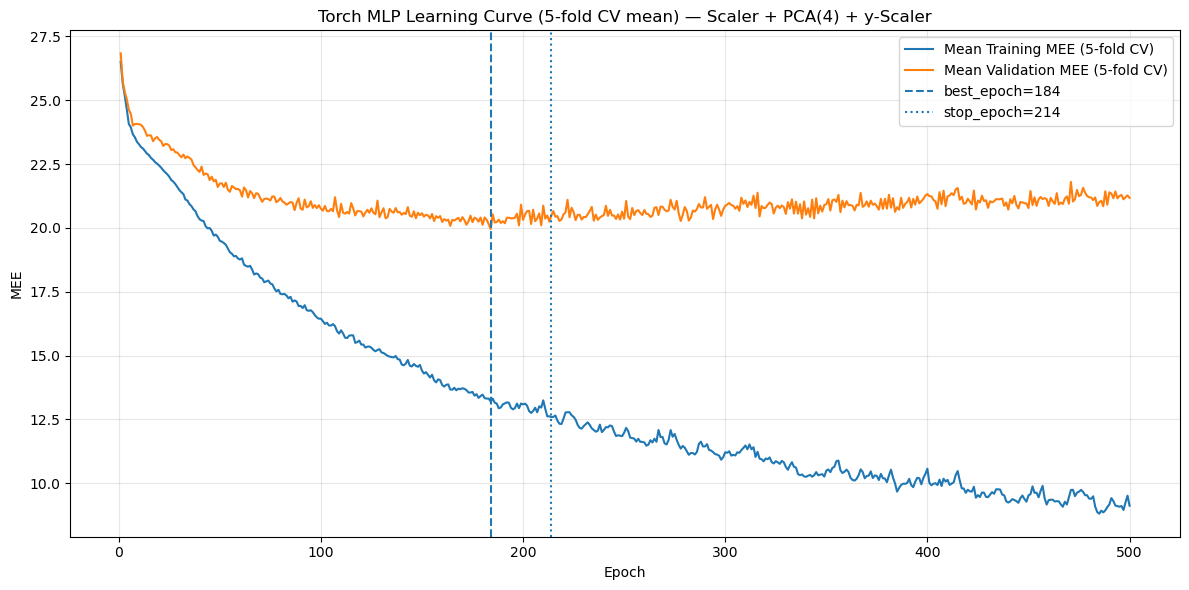

In [13]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
MLP_BEST = gs.best_params_

train_mean, val_mean = torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4,
    device=None,
    use_step_lr=False,
)

def early_stop_epoch(val_curve, patience=30, min_delta=1e-4, smooth_window=1):
    v = np.asarray(val_curve, dtype=float)

    # smoothing (moving average)
    if smooth_window and smooth_window > 1:
        k = np.ones(smooth_window) / smooth_window
        v_s = np.convolve(v, k, mode="same")
    else:
        v_s = v  # identical if smooth_window == 1

    best_val = np.inf
    best_ep0 = 0
    wait = 0
    stop_ep0 = len(v_s) - 1

    for ep0, val in enumerate(v_s):
        if val < best_val - min_delta:
            best_val = val
            best_ep0 = ep0
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                stop_ep0 = ep0
                break

    return best_ep0 + 1, stop_ep0 + 1, v[best_ep0], v_s

SMOOTH_W = 1

best_epoch, stop_epoch, best_val, val_smooth = early_stop_epoch(
    val_mean,
    patience=30,
    min_delta=1e-4,
    smooth_window=SMOOTH_W,
)

print(f"Early-stop selected best_epoch = {best_epoch} | best_val_MEE = {best_val:.6f}")
print(f"Early-stop would stop at epoch = {stop_epoch} (patience reached)")

# -------------------------
# PLOT
# -------------------------
epochs = np.arange(1, len(train_mean) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (5-fold CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (5-fold CV)")

if SMOOTH_W and SMOOTH_W > 1:
    plt.plot(epochs, val_smooth, linestyle="--", label=f"Smoothed Mean Val MEE (w={SMOOTH_W})")

plt.axvline(best_epoch, linestyle="--", label=f"best_epoch={best_epoch}")
plt.axvline(stop_epoch, linestyle=":",  label=f"stop_epoch={stop_epoch}")

plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("Torch MLP Learning Curve (5-fold CV mean) — Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

# phase 3

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, KFold

x_pipe = Pipeline([
    ("x_scaler", StandardScaler()),
    ("pca", PCA(n_components=4, random_state=SEED)),
    ("mlp", TorchMLPRegressor(device=str(DEVICE), random_state=SEED))
])

estimator = TransformedTargetRegressor(
    regressor=x_pipe,
    transformer=StandardScaler()
)

cv5 = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_splits = list(cv5.split(X_dev))

param_grid = {
    "regressor__mlp__optimizer": ["adam"], 
    "regressor__mlp__hidden_layer_sizes": [(64, 64), (32, 16), (32,), (128, 64), (64, 32)],
    "regressor__mlp__activation": ["relu", "tanh"],
    "regressor__mlp__batch_size": [128, 256],
    "regressor__mlp__lr": [2e-3, 5e-3, 3e-3],
    "regressor__mlp__beta1": [0.9],
    "regressor__mlp__beta2": [0.999],
    "regressor__mlp__eps": [1e-8],
    "regressor__mlp__amsgrad": [False],
    "regressor__mlp__weight_decay": [0.01, 1e-5, 1e-4, 1e-3],
    "regressor__mlp__max_epochs": [200],
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=mee_scorer,
    cv=cv_splits,
    n_jobs=1,      # torch + GPU: nên để 1
    refit=True,
    return_train_score=True,
    error_score=np.nan,
    verbose=2
)

gs.fit(X_dev, y_dev)
print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END regressor__mlp__activation=relu, regressor__mlp__amsgrad=False, regressor__mlp__batch_size=128, regressor__mlp__beta1=0.9, regressor__mlp__beta2=0.999, regressor__mlp__eps=1e-08, regressor__mlp__hidden_layer_sizes=(64, 64), regressor__mlp__lr=0.002, regressor__mlp__max_epochs=200, regressor__mlp__optimizer=adam, regressor__mlp__weight_decay=0.01; total time=   3.4s
[CV] END regressor__mlp__activation=relu, regressor__mlp__amsgrad=False, regressor__mlp__batch_size=128, regressor__mlp__beta1=0.9, regressor__mlp__beta2=0.999, regressor__mlp__eps=1e-08, regressor__mlp__hidden_layer_sizes=(64, 64), regressor__mlp__lr=0.002, regressor__mlp__max_epochs=200, regressor__mlp__optimizer=adam, regressor__mlp__weight_decay=0.01; total time=   3.3s
[CV] END regressor__mlp__activation=relu, regressor__mlp__amsgrad=False, regressor__mlp__batch_size=128, regressor__mlp__beta1=0.9, regressor__mlp__beta2=0.999, regressor__mlp__eps=1

In [15]:
import numpy as np

best_model = gs.best_estimator_  
y_int = np.asarray(y_int, dtype=np.float32)
y_int_pred = best_model.predict(X_int)

print("Internal 20% MEE:", mee(y_int, y_int_pred))

Internal 20% MEE: 19.155080795288086


Early-stop selected best_epoch = 456 | best_val_MEE = 20.000469
Early-stop would stop at epoch = 486 (patience reached)


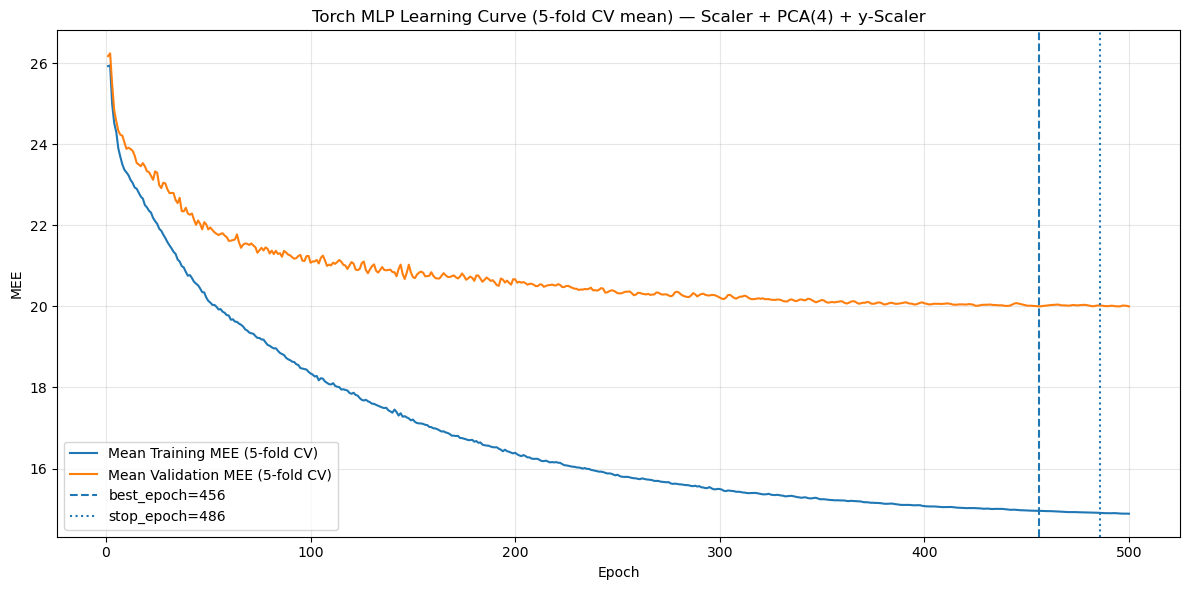

In [16]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
MLP_BEST = gs.best_params_

train_mean, val_mean = torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4,
    device=None,
    use_step_lr=True,
    step_lr_step_size=50,
    step_lr_gamma=0.7,
)

def early_stop_epoch(val_curve, patience=30, min_delta=1e-4, smooth_window=1):
    v = np.asarray(val_curve, dtype=float)

    # smoothing (moving average)
    if smooth_window and smooth_window > 1:
        k = np.ones(smooth_window) / smooth_window
        v_s = np.convolve(v, k, mode="same")
    else:
        v_s = v  # identical if smooth_window == 1

    best_val = np.inf
    best_ep0 = 0
    wait = 0
    stop_ep0 = len(v_s) - 1

    for ep0, val in enumerate(v_s):
        if val < best_val - min_delta:
            best_val = val
            best_ep0 = ep0
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                stop_ep0 = ep0
                break

    return best_ep0 + 1, stop_ep0 + 1, v[best_ep0], v_s

SMOOTH_W = 1

best_epoch, stop_epoch, best_val, val_smooth = early_stop_epoch(
    val_mean,
    patience=30,
    min_delta=1e-4,
    smooth_window=SMOOTH_W,
)

print(f"Early-stop selected best_epoch = {best_epoch} | best_val_MEE = {best_val:.6f}")
print(f"Early-stop would stop at epoch = {stop_epoch} (patience reached)")

# -------------------------
# PLOT
# -------------------------
epochs = np.arange(1, len(train_mean) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (5-fold CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (5-fold CV)")

# chỉ plot smooth nếu khác thật (smooth_window > 1)
if SMOOTH_W and SMOOTH_W > 1:
    plt.plot(epochs, val_smooth, linestyle="--", label=f"Smoothed Mean Val MEE (w={SMOOTH_W})")

plt.axvline(best_epoch, linestyle="--", label=f"best_epoch={best_epoch}")
plt.axvline(stop_epoch, linestyle=":",  label=f"stop_epoch={stop_epoch}")

plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("Torch MLP Learning Curve (5-fold CV mean) — Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

# phase 4

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, KFold

x_pipe = Pipeline([
    ("x_scaler", StandardScaler()),
    ("pca", PCA(n_components=4, random_state=SEED)),
    ("mlp", TorchMLPRegressor(device=str(DEVICE), random_state=SEED))
])

estimator = TransformedTargetRegressor(
    regressor=x_pipe,
    transformer=StandardScaler()
)

cv5 = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_splits = list(cv5.split(X_dev))

param_grid = {
    "regressor__mlp__optimizer": ["adam"], 
    "regressor__mlp__hidden_layer_sizes": [(128, 64)],
    "regressor__mlp__activation": ["relu"],
    "regressor__mlp__batch_size": [128],
    "regressor__mlp__lr": [2e-3, 5e-3, 3e-3],
    "regressor__mlp__beta1": [0.95, 1],
    "regressor__mlp__beta2": [0.9995, 0.9999],
    "regressor__mlp__eps": [1e-8, 1e-7],
    "regressor__mlp__amsgrad": [False],
    "regressor__mlp__weight_decay": [0.01, 1e-5, 1e-4, 1e-3],
    "regressor__mlp__max_epochs": [200],
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=mee_scorer,
    cv=cv_splits,
    n_jobs=1,      
    refit=True,
    return_train_score=True,
    error_score=np.nan,
    verbose=2
)

gs.fit(X_dev, y_dev)
print("Best params:", gs.best_params_)
print("Best CV MEE:", -gs.best_score_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END regressor__mlp__activation=relu, regressor__mlp__amsgrad=False, regressor__mlp__batch_size=128, regressor__mlp__beta1=0.95, regressor__mlp__beta2=0.9995, regressor__mlp__eps=1e-08, regressor__mlp__hidden_layer_sizes=(128, 64), regressor__mlp__lr=0.002, regressor__mlp__max_epochs=200, regressor__mlp__optimizer=adam, regressor__mlp__weight_decay=0.01; total time=  14.9s
[CV] END regressor__mlp__activation=relu, regressor__mlp__amsgrad=False, regressor__mlp__batch_size=128, regressor__mlp__beta1=0.95, regressor__mlp__beta2=0.9995, regressor__mlp__eps=1e-08, regressor__mlp__hidden_layer_sizes=(128, 64), regressor__mlp__lr=0.002, regressor__mlp__max_epochs=200, regressor__mlp__optimizer=adam, regressor__mlp__weight_decay=0.01; total time=   3.6s
[CV] END regressor__mlp__activation=relu, regressor__mlp__amsgrad=False, regressor__mlp__batch_size=128, regressor__mlp__beta1=0.95, regressor__mlp__beta2=0.9995, regressor__mlp_

C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\manht\AppData\Roaming\Python\Python312\sit

Best params: {'regressor__mlp__activation': 'relu', 'regressor__mlp__amsgrad': False, 'regressor__mlp__batch_size': 128, 'regressor__mlp__beta1': 0.95, 'regressor__mlp__beta2': 0.9999, 'regressor__mlp__eps': 1e-07, 'regressor__mlp__hidden_layer_sizes': (128, 64), 'regressor__mlp__lr': 0.005, 'regressor__mlp__max_epochs': 200, 'regressor__mlp__optimizer': 'adam', 'regressor__mlp__weight_decay': 0.0001}
Best CV MEE: 19.49450373694029


In [9]:
import numpy as np

best_model = gs.best_estimator_   
y_int = np.asarray(y_int, dtype=np.float32)
y_int_pred = best_model.predict(X_int)

print("Internal 20% MEE:", mee(y_int, y_int_pred))

Internal 20% MEE: 18.56609344482422


Early-stop selected best_epoch = 349 | best_val_MEE = 20.185750
Early-stop would stop at epoch = 379 (patience reached)


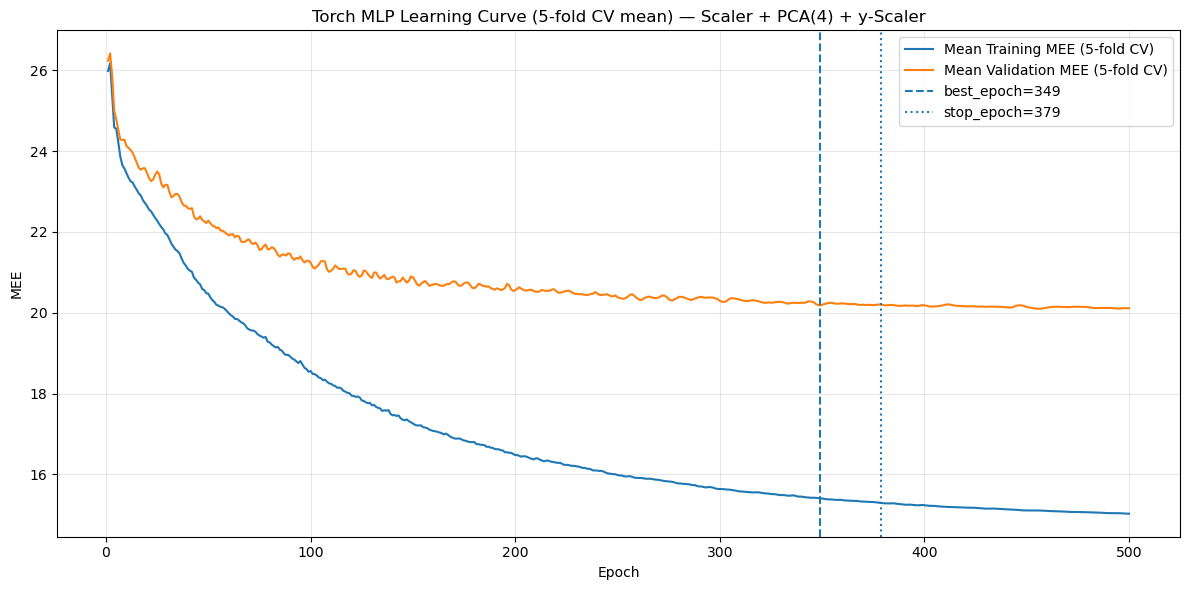

In [10]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

cv5 = KFold(n_splits=5, shuffle=True, random_state=42)
MLP_BEST = gs.best_params_

train_mean, val_mean = torch_mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    best_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4,
    device=None,
    use_step_lr=True,
    step_lr_step_size=50,
    step_lr_gamma=0.7,
)

def early_stop_epoch(val_curve, patience=30, min_delta=1e-4, smooth_window=1):
    v = np.asarray(val_curve, dtype=float)

    # smoothing (moving average)
    if smooth_window and smooth_window > 1:
        k = np.ones(smooth_window) / smooth_window
        v_s = np.convolve(v, k, mode="same")
    else:
        v_s = v  # identical if smooth_window == 1

    best_val = np.inf
    best_ep0 = 0
    wait = 0
    stop_ep0 = len(v_s) - 1

    for ep0, val in enumerate(v_s):
        if val < best_val - min_delta:
            best_val = val
            best_ep0 = ep0
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                stop_ep0 = ep0
                break

    return best_ep0 + 1, stop_ep0 + 1, v[best_ep0], v_s

SMOOTH_W = 1

best_epoch, stop_epoch, best_val, val_smooth = early_stop_epoch(
    val_mean,
    patience=30,
    min_delta=1e-4,
    smooth_window=SMOOTH_W,
)

print(f"Early-stop selected best_epoch = {best_epoch} | best_val_MEE = {best_val:.6f}")
print(f"Early-stop would stop at epoch = {stop_epoch} (patience reached)")

# PLOT
epochs = np.arange(1, len(train_mean) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (5-fold CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (5-fold CV)")

if SMOOTH_W and SMOOTH_W > 1:
    plt.plot(epochs, val_smooth, linestyle="--", label=f"Smoothed Mean Val MEE (w={SMOOTH_W})")

plt.axvline(best_epoch, linestyle="--", label=f"best_epoch={best_epoch}")
plt.axvline(stop_epoch, linestyle=":",  label=f"stop_epoch={stop_epoch}")

plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("Torch MLP Learning Curve (5-fold CV mean) — Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# train/val MEE tại best_epoch (index = epoch-1)
best_train = float(train_mean[best_epoch - 1])
best_val_at_best = float(val_mean[best_epoch - 1])  # khớp với best_epoch đã chọn

# (tuỳ chọn) train/val MEE tại stop_epoch
stop_train = float(train_mean[stop_epoch - 1])
stop_val = float(val_mean[stop_epoch - 1])

print(f"Early-stop selected best_epoch = {best_epoch} | "
      f"train_MEE = {best_train:.6f} | val_MEE = {best_val_at_best:.6f}")

print(f"Early-stop would stop at epoch = {stop_epoch} | "
      f"train_MEE = {stop_train:.6f} | val_MEE = {stop_val:.6f}")


Early-stop selected best_epoch = 349 | train_MEE = 15.412774 | val_MEE = 20.185750
Early-stop would stop at epoch = 379 | train_MEE = 15.292963 | val_MEE = 20.200301
